## HCBM Model

In their work, Marti et al, (2016) tried to answer the question, how long is enough? referring to how many days of return correlations of financial time series are
needed for clustering algorithms to avoid spurious results without losing dynamics.

They provide a method to generate correlation matrices that follow a hierarchical correlation block model structure (HCBM). Price time series of traded assets
have been observed and verified several times for different markets to follow this structure. The HCBM correlation matrices generated by this method can be
used to generate financial time series. The underlying distributions of the generated time series can be either a gaussian random walk model or an N-variate
Student's t-distribution. The former being the standard, but debated, model of quantitative finance for financial time series, and the latter being able to
capture heavy-tailed behavior and tail-dependence.


In [9]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
# import Genie

# Import MlFinLab packages
import os
os.environ['MLFINLAB_API_KEY'] = "0800b4ea410a702acddefdec86f93523"
from mlfinlab.data_generation.hcbm import generate_hcmb_mat, time_series_from_dist
from mlfinlab.data_generation.data_verification import plot_optimal_hierarchical_cluster

# Setting seed
np.random.seed(2814)

## HCBM

The HCBM model consists of correlation matrices having a hierarchical block structure. Each block corresponds to a correlation cluster.
The HCBM defines a set of nested partitions $P = \{P_0 \supseteq P_1 \supseteq ... \supseteq P_h\}$ for some $h \in [1, N]$ for $N$ univariate
random variables. Each partition is further subdivided and paritioned again for $k$ levels where $1 \leq k \leq h$. We define
$\underline{\rho_k}$ and $\bar{\rho_k}$ such that for all $1 \leq i,j \leq N$, we have $\underline{\rho_k} \leq \rho_{i,j} \leq \bar{\rho_k}$,
when $C^{(k)}(X_i) = C^{(k)}(X_j)$ and $C^{(k+1)}(X_i) \neq C^{(k+1)}(X_j)$ ($C^{(k)}(X_i)$ denotes the cluster $X_i$ in partition $P_k$).

This implies that $\underline{\rho_k}$ and $\bar{\rho_k}$ are the minimum and maximum correlation factors respectively within all clusters
$C^{(k)}_i$ in the partition $P_k$ at depth $k$. In order for the generated matrix to have a proper nested correlation hierarchy, we must have
$\bar{\rho_k} < \underline{\rho_{k+1}}$ hold true for all $k$.

## Simplified Explanation (I gotchu)

The HCBM model is a model for correlation matrices that have a hierarchical block structure. This means that each block in the matrix corresponds to a correlation cluster. The HCBM defines a set of nested partitions (a set of partitions where each partition is a subset of the previous partition) for some number of univariate random variables. Each partition is then subdivided and partitioned again for a certain number of levels. The HCBM model specifies the minimum and maximum correlation factors within all clusters in each partition. In order for the generated matrix to have a proper nested correlation hierarchy, the maximum correlation factor in each partition must be less than the minimum correlation factor in the partition below it.

Below we show how to generate and plot HCBM matrices with a maximum of 4 blocks per depth. Note that the number of blocks generated is randomly selected (from a uniform distribution) with the minimum number of blocks being 2. 

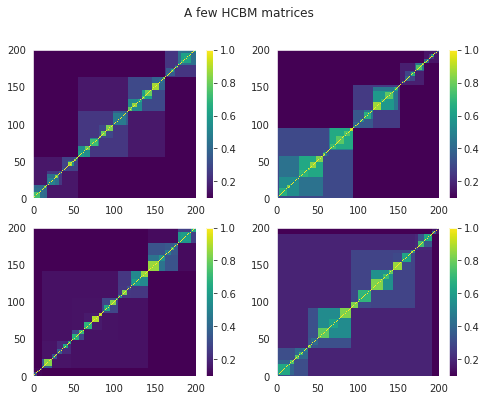

In [10]:
# Initialize parameters
samples = 4
dim = 200
rho_low = 0.1
rho_high = 0.9
blocks = 4
depth = 4

# Generate HCBM matrices
hcbm_mats = generate_hcmb_mat(t_samples=samples,
                              n_size=dim,
                              rho_low=rho_low,
                              rho_high=rho_high,
                              blocks=blocks,
                              depth=depth)
plt.figure(figsize=(8, 6))
plt.suptitle("A few HCBM matrices")

# Plot them
for i in range(len(hcbm_mats)):
    plt.subplot(2, 2, i + 1)
    plt.pcolormesh(hcbm_mats[i], cmap='viridis')
    plt.colorbar()

Usually, correlation matrices from asset returns do not exhibit the visual clustering as seen above. In order to try to replicate commonly observed correlation matrices, we can permute the HCBM matrices generated with the `permute` parameter.

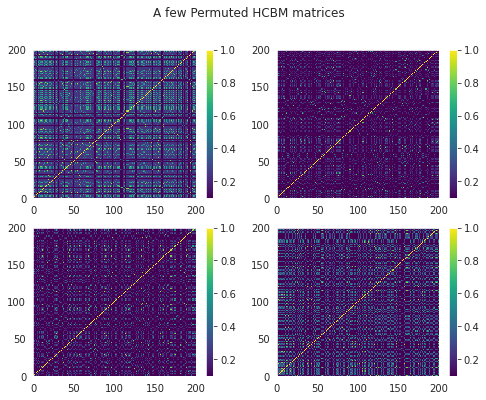

In [11]:
# Generate permuted HCBM matrices
hcbm_mats = generate_hcmb_mat(t_samples=samples,
                              n_size=dim,
                              rho_low=rho_low,
                              rho_high=rho_high,
                              blocks=blocks,
                              depth=depth,
                              permute=True)
plt.figure(figsize=(8, 6))
plt.suptitle("A few Permuted HCBM matrices")

# Plot them
for i in range(len(hcbm_mats)):
    plt.subplot(2, 2, i + 1)
    plt.pcolormesh(hcbm_mats[i], cmap='viridis')
    plt.colorbar()

In order to recover the hierarchical clustering, we can use the `plot_optimal_hierarchical_cluster` from our `data_verification` submodule. In order to only get the clustered matrix, use the `optimal_hierarchical_cluster` located in the `clustering` module

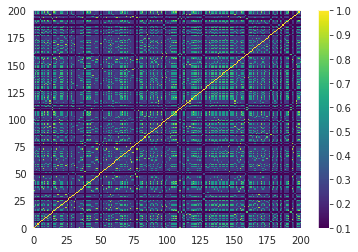

<Figure size 432x288 with 0 Axes>

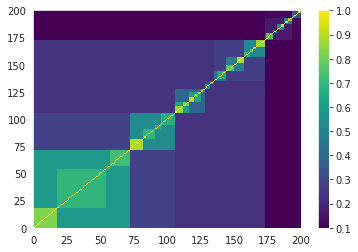

In [12]:
# Plot original matrix
plt.pcolormesh(hcbm_mats[0], cmap='viridis')
plt.colorbar()

# Plot optimal clustered matrix
plt.figure()
plot_optimal_hierarchical_cluster(hcbm_mats[0], method="ward")
plt.show();

Different block and depth levels will result in different HCBM matrices. Note that the correlation magnitude is proportional to the depth level. The deeper the level, the higher the correlation magnitude.

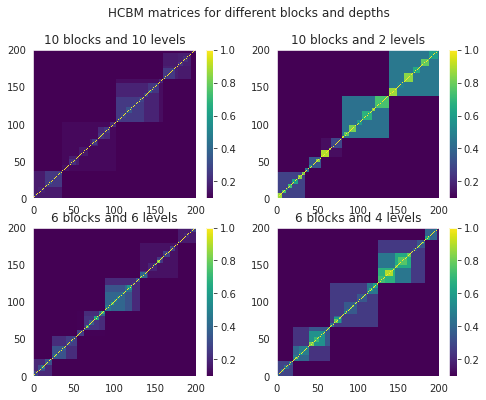

In [13]:
# Initialize parameters
samples = 1
dim = 200
rho_low = 0.1
rho_high = 0.9
blocks = [10, 10, 6, 6]
depth = [10, 2, 6, 4]
plt.figure(figsize=(8, 6))
plt.suptitle("HCBM matrices for different blocks and depths")

for i in range(len(depth)):

    # Generate HCBM matrices
    hcbm_mats = generate_hcmb_mat(t_samples=samples,
                                  n_size=dim,
                                  rho_low=rho_low,
                                  rho_high=rho_high,
                                  blocks=blocks[i],
                                  depth=depth[i])
    # Plot it
    plt.subplot(2, 2, i + 1)
    plt.pcolormesh(hcbm_mats[0], cmap='viridis')
    plt.colorbar()
    plt.title("{} blocks and {} levels".format(blocks[i], depth[i]))

In [ ]:
plot_optimal_hierarchical_cluster

## Time Series

To generate financial time series models from HCBM matrices we will consider two models.

- The standard, but not entirely accurate, gaussian random walk model. Its increments are realization from a $N$-variate Gaussian $X \sim N(0, \Sigma)$
- The $N$-variate Student's t-distribution, with degree of freedom $v = 3$, $X \sim t_v(0, \frac{v-2}{v}\Sigma)$

The advantage of using the $N$-variate Student's t-distribution is that it captures heavy-tailed behavior and tail-dependence. The authors assert that
"It has been shown that this distribution (Student's t-distribution) yields a much better fit to real returns than the Gaussian distribution"

Both distributions are parameterized by a covariance matrix $\Sigma$. We define $\Sigma$ such that the underlying correlation matrix has an HCBM
structure as shown in the figures above.

/home/ruben/Programs/anaconda3/envs/mini_Genie_ML/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/ruben/Programs/anaconda3/envs/mini_Genie_ML/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


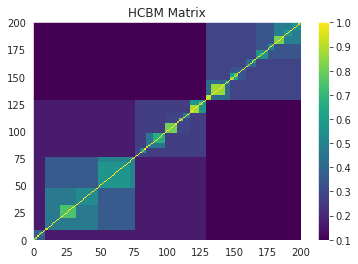

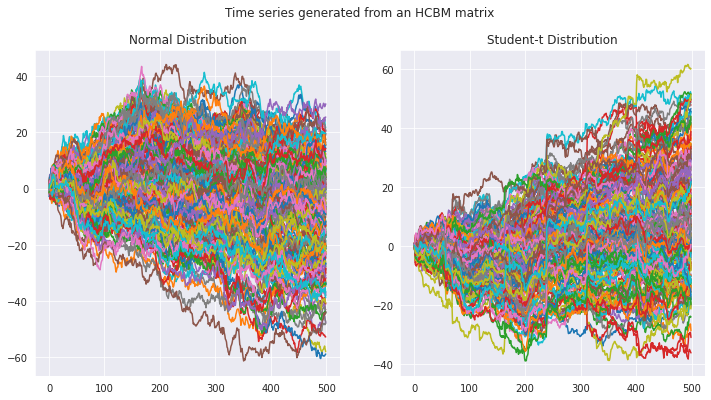

In [14]:
# Initialize parameters
samples = 1
dim = 200
rho_low = 0.1
rho_high = 0.9
t_samples = 500

# Generate time series from HCBM matrix
hcbm_mats = generate_hcmb_mat(t_samples=samples,
                              n_size=dim,
                              rho_low=rho_low,
                              rho_high=rho_high)

# Plot HCBM matrix
plt.pcolormesh(hcbm_mats[0], cmap='viridis')
plt.colorbar()
plt.title("HCBM Matrix")

# Generate time series
series_normal_df = time_series_from_dist(hcbm_mats[0], dist="normal", t_samples=t_samples)
series_student_df = time_series_from_dist(hcbm_mats[0], dist="student", t_samples=t_samples)

# Plot time series
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
series_normal_df.cumsum().plot(legend=None, ax=axes[0], title="Normal Distribution")
series_student_df.cumsum().plot(legend=None, ax=axes[1], title="Student-t Distribution")
plt.suptitle("Time series generated from an HCBM matrix")
plt.show()

We can recover the clustering of the correlation matrix of a time series by using the `plot_optimal_hierarchical_cluster` function. This will be demonstrated
by generating an HCBM matrix, permuting it, generating its time series, and using the time series' correlation matrix to recover the original HCBM matrix.

ValueError: iAt based indexing can only have integer indexers

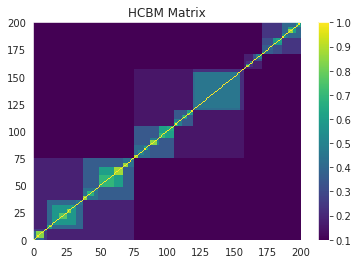

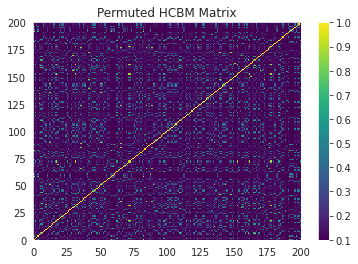

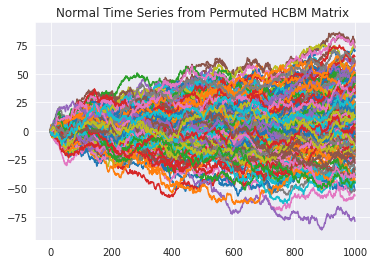

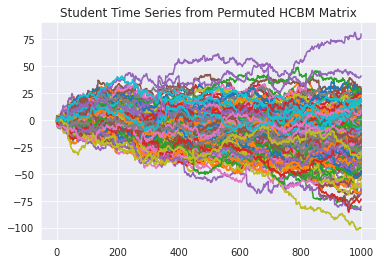

In [24]:
# Initialize parameters
samples = 1
dim = 200
rho_low = 0.1
rho_high = 0.9
t_samples = 1000
starting_price = 100

# Generate time series from HCBM matrix
hcbm_mats = generate_hcmb_mat(t_samples=samples,
                              n_size=dim,
                              rho_low=rho_low,
                              rho_high=rho_high)
# Plot HCBM matrix
plt.pcolormesh(hcbm_mats[0], cmap='viridis')
plt.colorbar()
plt.title("HCBM Matrix")

# Permute HCBM matrix
permuted_mat = hcbm_mats[0].copy()
perm = np.random.permutation(dim)
np.take(permuted_mat, perm, 0, out=permuted_mat)
np.take(permuted_mat, perm, 1, out=permuted_mat)


# Plot permuted HCBM matrix
plt.figure()
plt.pcolormesh(permuted_mat, cmap='viridis')
plt.colorbar()
plt.title("Permuted HCBM Matrix")

# Generate time series
series_normal_df = time_series_from_dist(permuted_mat, dist="normal", t_samples=t_samples)
series_student_df = time_series_from_dist(permuted_mat, dist="student", t_samples=t_samples)

# Plot time series
series_normal_df.cumsum().plot(legend=None,  title="Normal Time Series from Permuted HCBM Matrix")
series_student_df.cumsum().plot(legend=None,  title="Student Time Series from Permuted HCBM Matrix")

# Change first value of every column to starting price


plt.figure()
plot_optimal_hierarchical_cluster(series_normal_df.corr(), method="ward")
plt.title("Normal Recovered HCBM Matrix")

plt.figure()
plot_optimal_hierarchical_cluster(series_student_df.corr(), method="ward")
plt.title("Student Recovered HCBM Matrix")

plt.show();

We can notice the recovered HCBM matrix has all the underlying blocks, at different locations and magnitudes.

## Conclusion

In this notebook, we showed how to use our mlfinlab package to generate HCBM matrices and multiple time series from it. When permuted, the HCBM matrix closely resembles correlation matrices calculated from asset returns. It also demonstrated how we can leverage the optimal hierarchical clustering function to recover the HCBM matrix from a time series. To summarize, we found that:

1. An HCBM matrix can be generated for different correlation magnitudes, number of hierarchical blocks, and depth levels.
2. When permuted, an HCBM matrix resembles a correlation matrix calculated from asset returns.
3. We can generate a time series from an HCBM matrix with a normal or student-t distribution.
4. We can recover the underlying HCBM matrix of a time series by using an optimal hierarchical clustering algorithm.



[references]: #references
## References
1. [Marti, G., Andler, S., Nielsen, F. and Donnat, P., 2016. Clustering financial time series: How long is enough?. _arXiv preprint_ arXiv:1603.04017.](https://www.ijcai.org/Proceedings/16/Papers/367.pdf)